In this project we will use classification algorithms to see if we can successfully predict whether a customer is likely to respond positively to a campaign selling loans. Our features will all be data that the bank holds, such as the size of the customer's family, their income, their level of education and their existing loans.

In [14]:
# Import the data and the libraries we need
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
loans = pd.read_csv("C:\\Users\\user\\Desktop\\Data\\Personal loans.csv")
loans.head() # Visualise the data to check it looks right

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [15]:
# We're not interested in geographic variation, so we can drop that column straight away
loans.drop(["ZIP Code"], axis=1, inplace=True)
loans.head()

,ID,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,4,1.0,2,0,0,0,0,0,1


In [16]:
# Inspect the dataset for null values
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


count    5000.000000
mean       45.338400
std        11.463166
min        23.000000
25%        35.000000
50%        45.000000
75%        55.000000
max        67.000000
Name: Age, dtype: float64


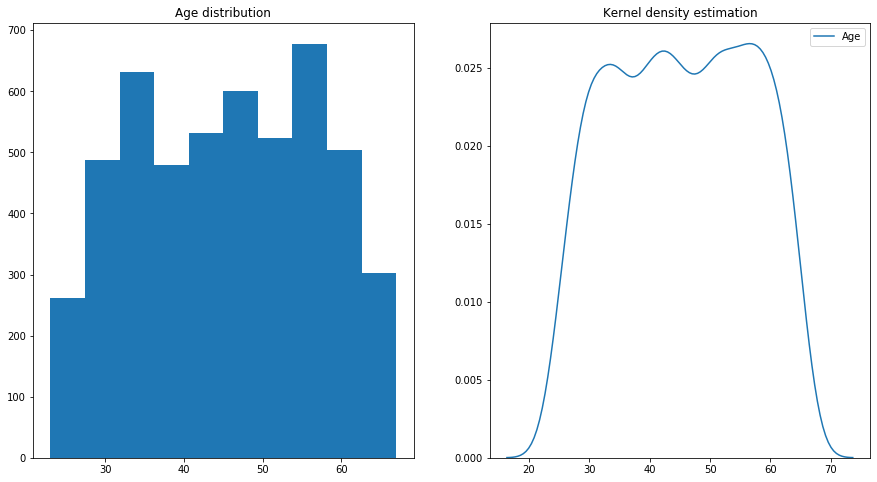

In [17]:
# No null values! Let's look at the age column in more detail and visualise the range
print(loans["Age"].describe())
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
ax1.hist(loans["Age"])
ax1.set_title("Age distribution")
sns.kdeplot(loans["Age"], ax=ax2)
ax2.set_title("Kernel density estimation")
plt.show()

So, between the ages of 25 and 70 our data follows a more or less normal distribution, and the meanage is 45. We'll now plot age vs income to see what relationship there is between the two.

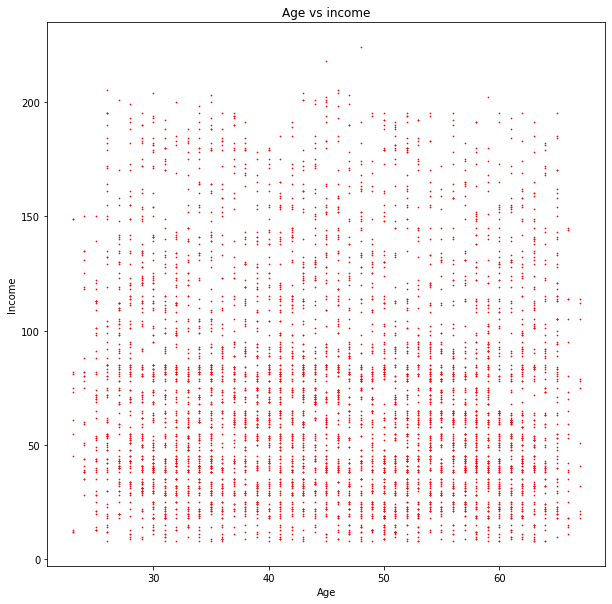

In [18]:
fig=plt.subplots(figsize=(10,10))
plt.scatter(loans["Age"], loans["Income"], s=0.5, c="red")
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Age vs income")
plt.show()

While we might expect there to be a clear linear relationship between the two, we really don't see
that here. Could this be explained by variations in the experience column, which covers length of time working? Let's see:

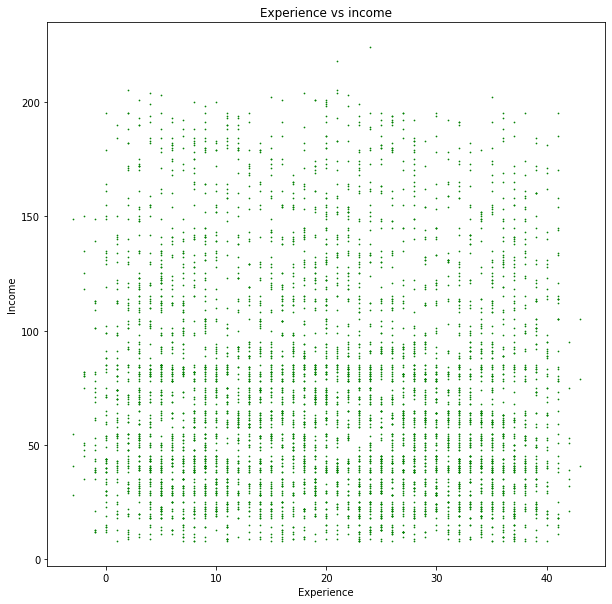

In [19]:
fig=plt.subplots(figsize=(10,10))
plt.scatter(loans["Experience"], loans["Income"], s=0.5, c="green")
plt.xlabel("Experience")
plt.ylabel("Income")
plt.title("Experience vs income")
plt.show()

Similarly, no clear linear relationship here between experience in the role and income. To quickly quantify the relationships between the continuous variables in the dataset, we can plot a correlation
heatmap:

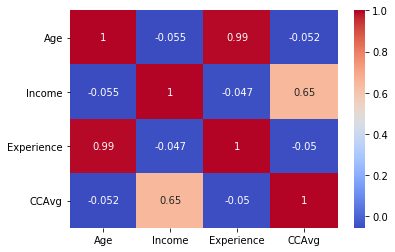

In [20]:
continuous = loans[["Age", "Income", "Experience", "CCAvg"]] # Make a new dataframe with continuous variables (except for mortgage value as this has lots of "0s")
sns.heatmap(continuous.corr(), cmap="coolwarm", annot=True)
plt.show()

We see very strong correlations between Age and Experience (as you would expect!), but after that the only strong relationship is between Income and CCAvg, or average expenditure per month. 

The next question we are seeking to answer is whether we can come up with a model that effectively predicts whether a customer will respond well to a campaign selling loans. The bank can then use this to more effectively target their advertising. This is a binary classification problem, as we are predicting simply whether a customer will, or will not, accept a personal loan. 

In [21]:
# Import our classification libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score # This is the metric we will use to evaluate the model
# Inspect the dataframe again to see our features
loans.head()

,ID,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,4,1.0,2,0,0,0,0,0,1


In [22]:
# Our target column is "Personal loan". We will use all of the other features:
from sklearn.model_selection import train_test_split
features_df = loans.drop(["ID", "Personal Loan"], axis=1)
features = features_df.columns
x = loans[features]
y = loans["Personal Loan"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1) # Split into train and test sets
lr = LogisticRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
print("First five predictions: ", predictions[:5])
print("Accuracy of logistic regression model: ", accuracy_score(predictions, y_test))


First five predictions:  [0 0 0 0 0]
Accuracy of logistic regression model:  0.943


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The model is 94% accurate, which is pretty impressive! We will now try the other two models to see if they represent any improvement

In [24]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
clf_predictions = clf.predict(x_test)
print("First five predictions: ", clf_predictions[:5])
print("Accuracy of decision tree classifier: ", accuracy_score(clf_predictions, y_test))
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_test)
print("First five predictions: ", knn_predictions[:5])
print("Accuracy of k nearest neighbours model: ", accuracy_score(knn_predictions, y_test))

First five predictions:  [0 0 0 0 0]
Accuracy of decision tree classifier:  0.981
First five predictions:  [0 0 0 0 0]
Accuracy of k nearest neighbours model:  0.909


So, the k nearest neighbors algorithm is the worst, at 91% accurate, but the decision tree classifier scored even higher than simple logistic regression and was able to predict with 98% accuracy. 